In [18]:
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tlo import Date
from tlo.analysis.utils import (
    extract_results,
    summarize,
)
import matplotlib.dates as mdates


In [ ]:
# Create pickles locally 
from tlo.analysis.utils import create_pickles_locally, parse_log_file

import fileinput
import gzip
import json
import os
import pickle
import warnings
from collections import Counter, defaultdict
from collections.abc import Mapping
from pathlib import Path
from types import MappingProxyType
from typing import Any, Callable, Dict, Iterable, List, Literal, Optional, TextIO, Tuple, Union

import git
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import squarify

from tlo import Date, Simulation, logging, util
from tlo.logging.reader import LogData
from tlo.util import (
    create_age_range_lookup,
    parse_csv_values_for_columns_with_mixed_datatypes,
    read_csv_files,
)

scenario_output_dir = '/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs_lhs_param_scan-2026-02-03T101537Z/'
def create_pickles_locally(scenario_output_dir, compressed_file_name_prefix=None):
    """For a run from the Batch system that has not resulted in the creation of the pickles, reconstruct the pickles
     locally."""
    def turn_log_into_pickles(logfile):
        print(f"Opening {logfile}")
        outputs = parse_log_file(logfile)
        for key, output in outputs.items():
            if key.startswith("tlo."):
                print(f" - Writing {key}.pickle")
                with open(logfile.parent / f"{key}.pickle", "wb") as f:
                    pickle.dump(output, f)
    
    def uncompress_and_save_logfile(compressed_file) -> Path:
        """Uncompress and save a log file (if gzipped) and return its path."""
        target = compressed_file.parent / str(compressed_file.name.replace('.gz', ''))
        
        try:
            # Try to open as gzipped file
            with gzip.open(compressed_file, 'rb') as s:
                content = s.read()
            with open(target, "wb") as t:
                t.write(content)
            return target
        except gzip.BadGzipFile:
            # Not a gzipped file, return the original file path
            print(f"File {compressed_file} is not gzipped, using as-is")
            return compressed_file
    
    draw_folders = [f for f in os.scandir(scenario_output_dir) if f.is_dir()]
    for draw_folder in draw_folders:
        run_folders = [f for f in os.scandir(draw_folder) if f.is_dir()]
        for run_folder in run_folders:
            # Find the original log-file written by the simulation
            if compressed_file_name_prefix is None:
                logfile = [x for x in os.listdir(run_folder) if x.endswith('.log')][0]
            else:
                compressed_file_name = [
                    x for x in os.listdir(run_folder) if x.startswith(compressed_file_name_prefix)
                ][0]
                logfile = uncompress_and_save_logfile(Path(run_folder) / compressed_file_name)
            turn_log_into_pickles(logfile)
# # get the pickled files if not generated at the batch run
create_pickles_locally(scenario_output_dir = scenario_output_dir, compressed_file_name_prefix='climate_scenario_runs_lhs_param_scan')


Opening /Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs_lhs_param_scan-2026-02-03T101537Z/135/0/climate_scenario_runs_lhs_param_scan__2026-02-03T102038.log
Processing log file /Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs_lhs_param_scan-2026-02-03T101537Z/135/0/climate_scenario_runs_lhs_param_scan__2026-02-03T102038.log
Writing module-specific log files to /Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs_lhs_param_scan-2026-02-03T101537Z/135/0
Finished writing module-specific log files.
 - Writing tlo.simulation.pickle
 - Writing tlo.scenario.pickle
 - Writing tlo.methods.demography.pickle
 - Writing tlo.methods.healthburden.pickle
 - Writing tlo.methods.healthsystem.pickle
 - Writing tlo.methods.healthsystem.summary.pickle
 - Writing tlo.population.pickle
File /Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs_lhs_param_scan-2026-02-03T101537Z/61/0/

In [19]:
results_folder = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs_lhs_param_scan-2026-02-03T101537Z')

output_folder = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs_lhs_param_scan-2026-02-03T101537Z')

In [20]:
climate_sensitivity_analysis = False
main_text = False
parameter_uncertainty_analysis = True

if parameter_uncertainty_analysis:
    scenario_names = range(0,  200, 1)
    scenarios_of_interest = scenario_names
    suffix = "parameter_UA"
if main_text:
    scenario_names = [
        "Baseline",
        "Best Case",
        "Worst Case"
    ]
    suffix = "main_text"
    scenarios_of_interest = [0, 1]#, 2]


In [21]:

min_year = 2025
max_year = 2041
spacing_of_years = 1


In [22]:
target_year_sequence = range(min_year, max_year, spacing_of_years)

# Define the extraction functions (add these near your other helper functions)
def get_num_treatments_total_delayed(_df):
    """Count total number of delayed HSI events"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    print(_df)
    return pd.Series(len(_df), name="total")

def get_num_treatments_total_cancelled(_df):
    """Count total number of cancelled HSI events"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    return pd.Series(len(_df), name="total")

def get_num_treatments_total(_df):
    """Sum all treatment counts"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    total = {}
    for d in _df["hsi_event_key_to_counts"]:
        for k, v in d.items():
            total[k] = total.get(k, 0) + v
    print(sum(total.values()))
    return pd.Series(sum(total.values()), name="total")

def get_num_dalys_total(_df):
        """Return total number of DALYS (Stacked) by label (total by age-group within the TARGET_PERIOD)
        """
        return pd.Series(_df \
            .loc[_df.year.between(*[i.year for i in TARGET_PERIOD])] \
            .drop(columns=['date', 'sex', 'age_range', 'year']) \
            .sum().sum(), name="total")

def get_num_dalys_by_month(_df):
    """Sum all DALYs across all causes by month for the target year"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]

    # Sum across all disease columns (excluding non-disease columns)
    disease_columns = [col for col in _df.columns
                      if col not in ['age_range', 'month', 'sex', 'year', 'date']]

    # Group by month and sum
    monthly_dalys = _df.groupby('month')[disease_columns].sum().sum(axis=1)

    return monthly_dalys

def get_population_for_year(_df):
        """Returns the population in the year of interest"""
        _df["date"] = pd.to_datetime(_df["date"])

        # Filter the DataFrame based on the target period
        filtered_df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
        numeric_df = filtered_df.drop(columns=["female", "male"], errors="ignore")
        population_sum = numeric_df.sum(numeric_only=True)

        return population_sum


In [35]:
results_folder_baseline = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/baseline_run_with_pop-2026-02-05T113912Z')
results_folder_climate = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs_lhs_param_scan-2026-02-03T101537Z')

# Helper functions
def get_hsi_counts_by_facility_monthly(_df):
    """Get HSI counts by facility_id and month"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]

    if len(_df) == 0:
        return pd.Series(dtype=int)

    # Create keys like "2010-02_128" (month_facilityID)
    facility_month_totals = {}
    for _, row in _df.iterrows():
        month_key = row['date'].strftime('%Y-%m')
        counts_dict = row['counts']

        for key, value in counts_dict.items():
            if ':' in key:
                facility_id, _ = key.split(':', 1)
                facility_month_totals[facility_id] = facility_month_totals.get(facility_id, 0) + value

    return pd.Series(facility_month_totals)

def get_num_treatments_by_facility_delayed(_df):
    """Count number of delayed HSI events by facility"""
    print(_df)
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    
    if len(_df) == 0:
        return pd.Series(dtype=int, name="delayed_count")
    
    # Group by Facility_ID and count
    delayed_by_facility = _df.groupby('Facility_ID').size()
    delayed_by_facility.name = 'delayed_count'
    
    return delayed_by_facility


def get_num_treatments_by_facility_cancelled(_df):
    """Count number of cancelled HSI events by facility"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    
    if len(_df) == 0:
        return pd.Series(dtype=int, name="cancelled_count")
    
    # Group by Facility_ID and count
    cancelled_by_facility = _df.groupby('Facility_ID').size()
    cancelled_by_facility.name = 'cancelled_count'
    
    return cancelled_by_facility

# Storage dictionaries
all_scenarios_appointment_delayed_mean = {}
all_scenarios_appointment_cancelled_mean = {}
all_scenarios_dalys_mean = {}
# Get denominators 
baseline_hsi_by_facility = {}
    
for target_year in target_year_sequence:
        TARGET_PERIOD = (Date(target_year, 1, 1), Date(target_year, 12, 31))

        # Get baseline HSI by facility from BASELINE folder (DENOMINATOR)
        hsi_by_facility = summarize(extract_results(
            results_folder_baseline,  # ← Still from baseline
            module='tlo.methods.healthsystem.summary',
            key='hsi_event_counts_by_facility_monthly',
            custom_generate_series=get_hsi_counts_by_facility_monthly,
            do_scaling=False
        ), only_mean=True, collapse_columns=False)[0]
        
        # Fix index to be int
        hsi_by_facility.index = pd.Index([int(x) for x in hsi_by_facility.index], name='Facility_ID')
        baseline_hsi_by_facility[target_year] = hsi_by_facility

# Main loop
for draw in range(len(scenarios_of_interest)):
    print(draw)
    all_years_data_delayed_mean = {}
    all_years_data_cancelled_mean = {}
    all_years_dalys_mean = {}
    
    for target_year in target_year_sequence:
            TARGET_PERIOD = (Date(target_year, 1, 1), Date(target_year, 12, 31))

            # Get delayed counts BY FACILITY from CLIMATE folder (NUMERATOR)
            num_delayed_by_facility = summarize(extract_results(
                results_folder_climate,  # ← Changed from results_folder_baseline
                module='tlo.methods.healthsystem.summary',
                key='Weather_delayed_HSI_Event_full_info',
                custom_generate_series=get_num_treatments_by_facility_delayed,
                do_scaling=False
            ), only_mean=True, collapse_columns=False)#[draw]

            # Get cancelled counts BY FACILITY from CLIMATE folder (NUMERATOR)
            num_cancelled_by_facility = summarize(extract_results(
                results_folder_climate,  # ← Changed from results_folder_baseline
                module='tlo.methods.healthsystem.summary',
                key='Weather_cancelled_HSI_Event_full_info',
                custom_generate_series=get_num_treatments_by_facility_cancelled,
                do_scaling=False
            ), only_mean=True, collapse_columns=False)#[draw]

            # Align and divide by baseline (from baseline folder)
            baseline_aligned, delayed_aligned = baseline_hsi_by_facility[target_year].align(num_delayed_by_facility, fill_value=0)
            delayed_proportions = delayed_aligned / baseline_aligned
            
            baseline_aligned, cancelled_aligned = baseline_hsi_by_facility[target_year].align(num_cancelled_by_facility, fill_value=0)
            cancelled_proportions = cancelled_aligned / baseline_aligned
            
            all_years_data_delayed_mean[target_year] = delayed_proportions
            all_years_data_cancelled_mean[target_year] = cancelled_proportions

    all_scenarios_appointment_delayed_mean[draw] = all_years_data_delayed_mean
    all_scenarios_appointment_cancelled_mean[draw] = all_years_data_cancelled_mean
    all_scenarios_dalys_mean[draw] = all_years_dalys_mean

/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


KeyboardInterrupt: 

ValueError: x and y can be no greater than 2D, but have shapes (16,) and (16, 99, 103)

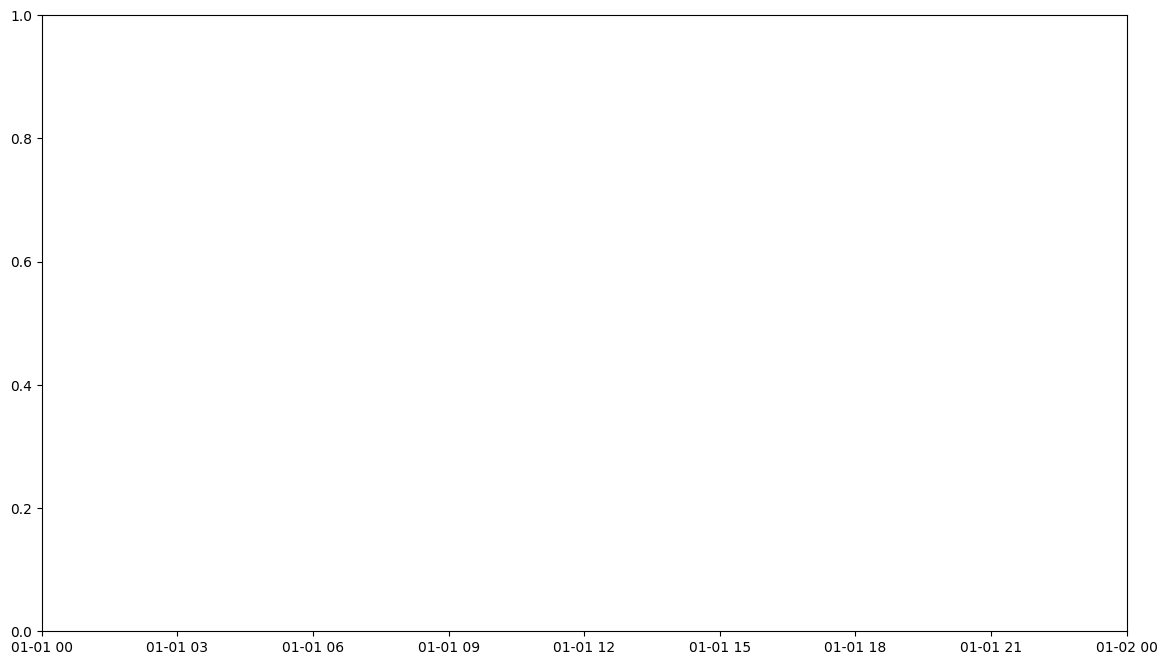

In [28]:
# Create a single plot for all draws with distribution
fig, ax1 = plt.subplots(figsize=(14, 8))

# Set opacity for individual draws
draw_alpha = 0.15  # Low opacity to see distribution

# First, let's check the data structure and extract properly
all_delayed_data = []
all_cancelled_data = []
all_total_data = []

for i, draw in enumerate(scenarios_of_interest):
    delayed_by_scenario = all_scenarios_appointment_delayed_mean[draw]
    cancelled_by_scenario = all_scenarios_appointment_cancelled_mean[draw]
    
    # Check if it's a dict (original structure) or array
    if isinstance(delayed_by_scenario, dict):
        # Original structure - dictionary by year
        delayed_all_years = [delayed_by_scenario[year].mean() if isinstance(delayed_by_scenario[year], pd.Series) else delayed_by_scenario[year] 
                             for year in sorted(delayed_by_scenario.keys())]
        cancelled_all_years = [cancelled_by_scenario[year].mean() if isinstance(cancelled_by_scenario[year], pd.Series) else cancelled_by_scenario[year]
                               for year in sorted(cancelled_by_scenario.keys())]
    else:
        # Array structure - need to aggregate across facilities
        # Assuming shape is (years, facilities, ...) or similar
        if len(delayed_by_scenario.shape) == 3:
            # If 3D: (years, facilities, something) - take mean across last two dimensions
            delayed_all_years = delayed_by_scenario.mean(axis=(1, 2))
            cancelled_all_years = cancelled_by_scenario.mean(axis=(1, 2))
        elif len(delayed_by_scenario.shape) == 2:
            # If 2D: (years, facilities) - take mean across facilities
            delayed_all_years = delayed_by_scenario.mean(axis=1)
            cancelled_all_years = cancelled_by_scenario.mean(axis=1)
        else:
            # If 1D: already aggregated
            delayed_all_years = delayed_by_scenario
            cancelled_all_years = cancelled_by_scenario
    
    delayed_data = np.array(delayed_all_years, dtype=float) * 100
    cancelled_data = np.array(cancelled_all_years, dtype=float) * 100
    total_data = delayed_data + cancelled_data
    
    # Store for potential summary statistics later
    all_delayed_data.append(delayed_data)
    all_cancelled_data.append(cancelled_data)
    all_total_data.append(total_data)

# Convert to arrays for easier manipulation
all_delayed_data = np.array(all_delayed_data)  # Shape: (n_draws, n_years)
all_cancelled_data = np.array(all_cancelled_data)
all_total_data = np.array(all_total_data)

# Create date axis
n_years = all_delayed_data.shape[1]
start_year = 2025
years = list(range(start_year, start_year + n_years))
start_date = pd.to_datetime([f'{y}-01-01' for y in years])

# Plot all draws with low opacity
for i in range(len(scenarios_of_interest)):
    if i == 0:
        ax1.plot(start_date, all_delayed_data[i], linewidth=1, color='#FF8C00', alpha=draw_alpha, 
                label=f"Delayed (n={len(scenarios_of_interest)} draws)")
        ax1.plot(start_date, all_cancelled_data[i], linewidth=1, color='#DC143C', alpha=draw_alpha,
                label=f"Cancelled (n={len(scenarios_of_interest)} draws)")
        ax1.plot(start_date, all_total_data[i], linewidth=1, color='#4169E1', alpha=draw_alpha, linestyle='--',
                label=f"Total Disrupted (n={len(scenarios_of_interest)} draws)")
    else:
        ax1.plot(start_date, all_delayed_data[i], linewidth=1, color='#FF8C00', alpha=draw_alpha)
        ax1.plot(start_date, all_cancelled_data[i], linewidth=1, color='#DC143C', alpha=draw_alpha)
        ax1.plot(start_date, all_total_data[i], linewidth=1, color='#4169E1', alpha=draw_alpha, linestyle='--')

# === Add ANC disruption data (bold) ===
ssp = "ssp245"
model = "mean"
end_year = start_year + n_years - 1

# Load ANC disruption resource file
anc_disruption_df = pd.read_csv(
    f"/Users/rem76/PycharmProjects/TLOmodel/resources/climate_change_impacts/"
    f"ResourceFile_Precipitation_Disruptions_{ssp}_{model}.csv"
)

# Filter ANC disruption data to match simulation period
anc_disruption_df = anc_disruption_df[
    (anc_disruption_df["year"] >= start_year) &
    (anc_disruption_df["year"] <= end_year)
]

# Calculate mean across all facilities by year
avg_df = anc_disruption_df.groupby(["year"], as_index=False)["mean_all_service"].mean()
avg_df = avg_df.sort_values(["year"])
anc_disruption_values = avg_df["mean_all_service"].values * 100

# Plot ANC data with bold, high opacity line
ax1.plot(start_date, anc_disruption_values, label="ANC Disruptions (expected)", 
         linewidth=3, color='purple', linestyle='-', alpha=1.0, zorder=10)

# Format plot
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.YearLocator())
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

ax1.set_xlabel("Time Period", fontsize=12)
ax1.set_ylabel("% Appointments Disrupted (mean across facilities)", fontsize=12)
ax1.set_title(f"Appointment Disruptions Across {len(scenarios_of_interest)} Model Draws\nvs Expected ANC Disruptions (SSP2-4.5)", 
             fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle=':')
ax1.legend(loc='best', fontsize=10)

plt.tight_layout()
# plt.savefig(output_folder / f"all_draws_disruptions_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Plotted {len(scenarios_of_interest)} draws")
print(f"Delayed data shape: {all_delayed_data.shape}")
print(f"Mean across draws - Delayed: {all_delayed_data.mean(axis=0).mean():.2f}%")
print(f"Mean across draws - Cancelled: {all_cancelled_data.mean(axis=0).mean():.2f}%")
print(f"Mean across draws - Total: {all_total_data.mean(axis=0).mean():.2f}%")